<a href="https://colab.research.google.com/github/johanjun/dacon_growthperiod/blob/main/training1209.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from tqdm import tqdm

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [2]:
root_dir = '/content/drive/MyDrive/dacon_growthperiod/open'
train_data_dir = os.path.join(root_dir, 'train_dataset')
test_data_dir = os.path.join(root_dir, 'test_dataset')

In [3]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [4]:
train_dir = os.path.join(train_data_dir, 'train')
val_dir = os.path.join(train_data_dir, 'validation')

tfr_dir = os.path.join(train_data_dir, 'tfrecord')

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [5]:
n_train = 11690
n_val = 2923

In [39]:
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [7]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'delta': tf.io.FixedLenFeature([], tf.string),
              'time_delta': tf.io.FixedLenFeature([], tf.int64)         
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    delta = tf.io.decode_raw(parsed_features['delta'], tf.uint8)    
    delta = tf.reshape(delta, [IMG_SIZE, IMG_SIZE, 3])
    delta = tf.cast(delta, tf.float32)/255.

    time_delta = tf.cast(parsed_features['time_delta'], tf.int64)

    return delta, time_delta

In [8]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [9]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

tf.Tensor(24, shape=(), dtype=int64)


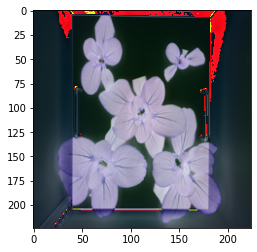

tf.Tensor(13, shape=(), dtype=int64)


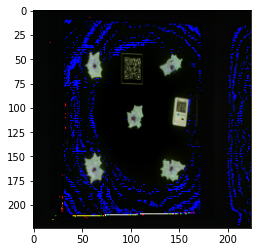

tf.Tensor(6, shape=(), dtype=int64)


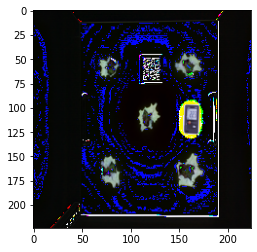

In [12]:
for delta, time_delta in train_dataset.take(3):
  print(time_delta[0])
  plt.imshow(delta[0])
  plt.show()

In [31]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [46]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [47]:
def create_mv_model():
  model = models.Sequential()
  model.add(mobilenetv2)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1))
  return model

In [48]:
# # Sequential API를 사용하여 model 구성
# def create_model():
#     model = keras.Sequential()
#     model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
#                                   input_shape=(IMG_SIZE, IMG_SIZE, 3)))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.MaxPool2D(padding='SAME'))
#     model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.MaxPool2D(padding='SAME'))
#     model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.MaxPool2D(padding='SAME'))
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(256, activation='relu'))
#     model.add(keras.layers.Dropout(0.4))
#     model.add(keras.layers.Dense(10, activation='relu'))
#     model.add(Dense(1))
#     return model

In [49]:
## Create model, compile & summary
model = create_mv_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='mse',
              metrics=['mse'])

In [50]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
292/292 [==============================] - 73s 213ms/step - loss: 25.7299 - mse: 25.7299 - val_loss: 14.1528 - val_mse: 14.1528
Epoch 2/20
292/292 [==============================] - 66s 208ms/step - loss: 3.7712 - mse: 3.7712 - val_loss: 14.2100 - val_mse: 14.2100
Epoch 3/20
292/292 [==============================] - 65s 207ms/step - loss: 2.4392 - mse: 2.4392 - val_loss: 8.2809 - val_mse: 8.2809
Epoch 4/20
292/292 [==============================] - 66s 208ms/step - loss: 1.8421 - mse: 1.8421 - val_loss: 6.6733 - val_mse: 6.6733
Epoch 5/20
292/292 [==============================] - 66s 208ms/step - loss: 1.4003 - mse: 1.4003 - val_loss: 9.9494 - val_mse: 9.9494
Epoch 6/20
292/292 [==============================] - 66s 209ms/step - loss: 0.9607 - mse: 0.9607 - val_loss: 7.9337 - val_mse: 7.9337
Epoch 7/20
292/292 [==============================] - 66s 207ms/step - loss: 0.8165 - mse: 0.8165 - val_loss: 4.3445 - val_mse: 4.3445
Epoch 8/20
292/292 [=============================

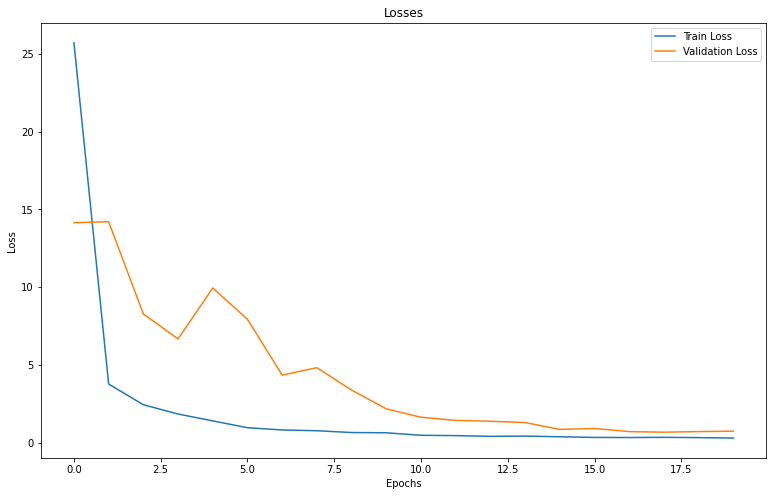

In [51]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

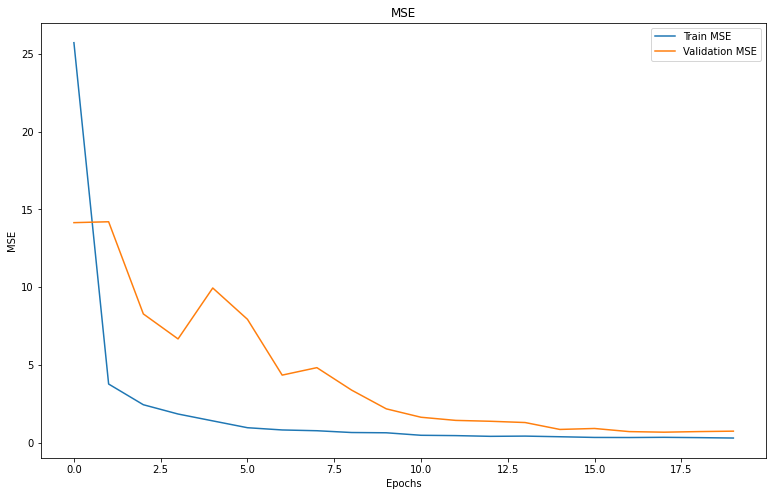

In [52]:
plt.figure(figsize = (13,8))
plt.plot(history.history["mse"], label = "Train MSE")
plt.plot(history.history["val_mse"],label = "Validation MSE")
plt.title("MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

tf.Tensor(10, shape=(), dtype=int64)


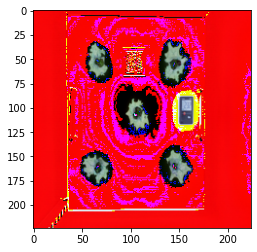

[9.629352]
tf.Tensor(20, shape=(), dtype=int64)


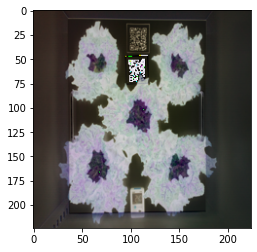

[20.093334]
tf.Tensor(1, shape=(), dtype=int64)


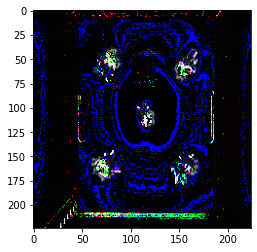

[1.1083509]
tf.Tensor(20, shape=(), dtype=int64)


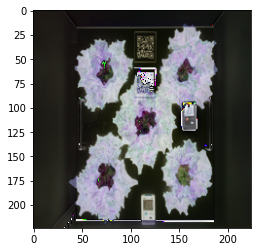

[20.35882]
tf.Tensor(26, shape=(), dtype=int64)


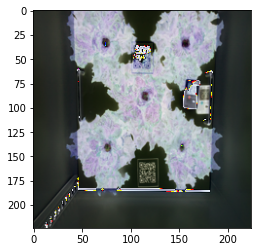

[26.227907]


In [53]:
for delta, time_delta in train_dataset.take(5):
  print(time_delta[5])
  plt.imshow(delta[5])
  plt.show()

  pred = model.predict(delta)
  print(pred[5])

#pred

In [54]:
test_set = pd.read_csv('/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/test_data.csv')
test_set['l_root'] = test_set['before_file_path'].map(lambda x: '/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/' + x.split('_')[1] + '/' + x.split('_')[2])
test_set['r_root'] = test_set['after_file_path'].map(lambda x: '/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/' + x.split('_')[1] + '/' + x.split('_')[2])
test_set['l_path'] = test_set['l_root'] + '/' + test_set['before_file_path'] + '.png'
test_set['r_path'] = test_set['r_root'] + '/' + test_set['after_file_path'] + '.png'

In [55]:
test_set.head()

,idx,before_file_path,after_file_path,l_root,r_root,l_path,r_path
0,0,idx_LT_1003_00341,idx_LT_1003_00154,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
1,1,idx_LT_1003_00592,idx_LT_1003_00687,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
2,2,idx_BC_1100_00445,idx_BC_1100_00840,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
3,3,idx_BC_1112_00229,idx_BC_1112_00105,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
4,4,idx_LT_1088_00681,idx_LT_1088_00698,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...


In [56]:
print(test_set.iloc[0].l_root)
test_set.iloc[0].l_path

/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003


'/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003/idx_LT_1003_00341.png'

In [57]:
print(test_set.iloc[0].r_root)
test_set.iloc[0].r_path

/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003


'/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003/idx_LT_1003_00154.png'

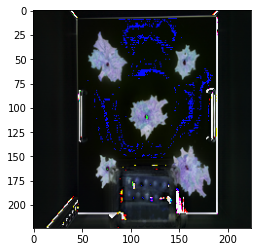

[[24.122427]]


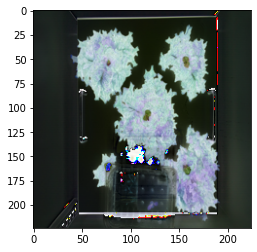

[[28.813055]]


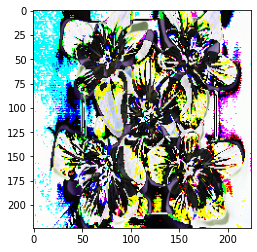

[[6.008382]]


In [58]:
for i, v in test_set[:3].iterrows():
  before_image = Image.open(v.l_path)
  before_image = before_image.resize((224, 224))

  after_image = Image.open(v.r_path)
  after_image = after_image.resize((224, 224))

  delta = np.array(before_image) - np.array(after_image)


  delta = tf.reshape(delta, [1, IMG_SIZE, IMG_SIZE, 3])
  delta = tf.cast(delta, tf.float32)/255

  plt.imshow(tf.reshape(delta, [IMG_SIZE, IMG_SIZE, 3]))
  plt.show()

  pred = model.predict(delta)
  print(pred)

  

In [59]:
len(test_set)

3960

In [61]:
pred_res = []
delta_res = []
for i, v in tqdm(test_set.iterrows()):
  before_image = Image.open(v.l_path)
  before_image = before_image.resize((224, 224))

  after_image = Image.open(v.r_path)
  after_image = after_image.resize((224, 224))

  delta = np.array(before_image) - np.array(after_image)
  delta = tf.reshape(delta, [1, IMG_SIZE, IMG_SIZE, 3])
  delta = tf.cast(delta, tf.float32)/255

  delta_res.append(delta)

  pred = model.predict(delta)
  pred_res.append(pred)

3960it [44:58,  1.47it/s]


In [62]:
import pickle
with open('delta.pkl', 'wb') as f:
  pickle.dump(delta, f)

In [63]:
pred_res[:10]

[array([[24.122427]], dtype=float32),
 array([[28.813055]], dtype=float32),
 array([[6.008382]], dtype=float32),
 array([[4.598663]], dtype=float32),
 array([[24.516737]], dtype=float32),
 array([[21.814896]], dtype=float32),
 array([[19.110151]], dtype=float32),
 array([[12.953513]], dtype=float32),
 array([[1.1606476]], dtype=float32),
 array([[29.617758]], dtype=float32)]

In [64]:
ans = [float(p) for p in pred_res]

In [65]:
sub = pd.read_csv('/content/drive/MyDrive/dacon_growthperiod/open/sample_submission.csv')

In [67]:
sub['time_delta'] = pd.Series(ans)

In [68]:
sub.head()

,idx,time_delta
0,0,24.122427
1,1,28.813055
2,2,6.008382
3,3,4.598663
4,4,24.516737


In [69]:
cd '/content/drive/MyDrive/dacon_growthperiod/open/submission'

/content/drive/MyDrive/dacon_growthperiod/open/submission


In [70]:
sub.set_index('idx', drop=True, inplace=True)

In [71]:
sub.head()

,time_delta
idx,
0,24.122427
1,28.813055
2,6.008382
3,4.598663
4,24.516737


In [72]:
sub.to_csv('1209-1.csv')